In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize']=20,8
plt.style.use('ggplot')

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
google=pd.read_csv('stock_data/GOOGL_2006-01-01_to_2018-01-01.csv', parse_dates=True, index_col='Date')
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


# EDA

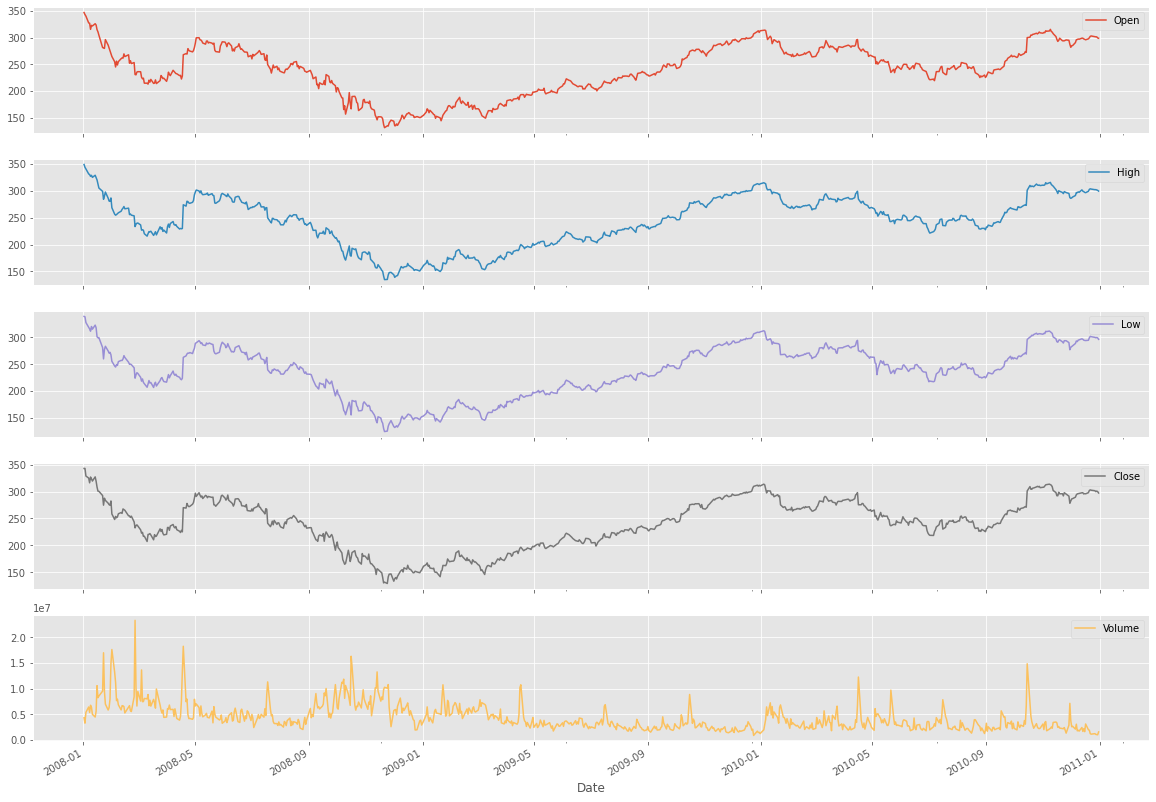

In [3]:
google['2008':'2010'].plot(subplots=True, figsize=(20,15));

## Finance & Statistics

### Percent Change

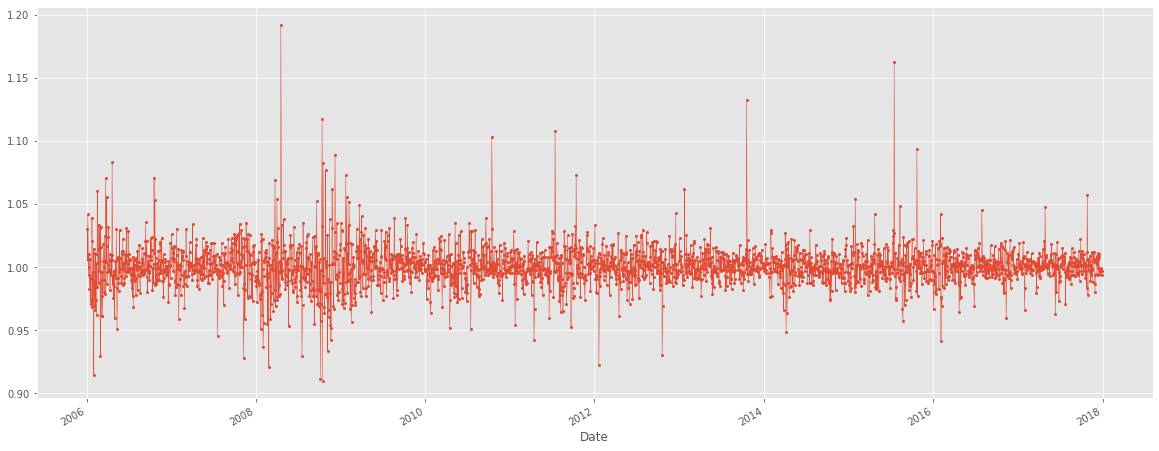

In [4]:
google['Change']=google['High'].div(google['High'].shift(1))
google['Change'].plot(linewidth=0.5, marker='o', markersize=2);

### Stock Returns

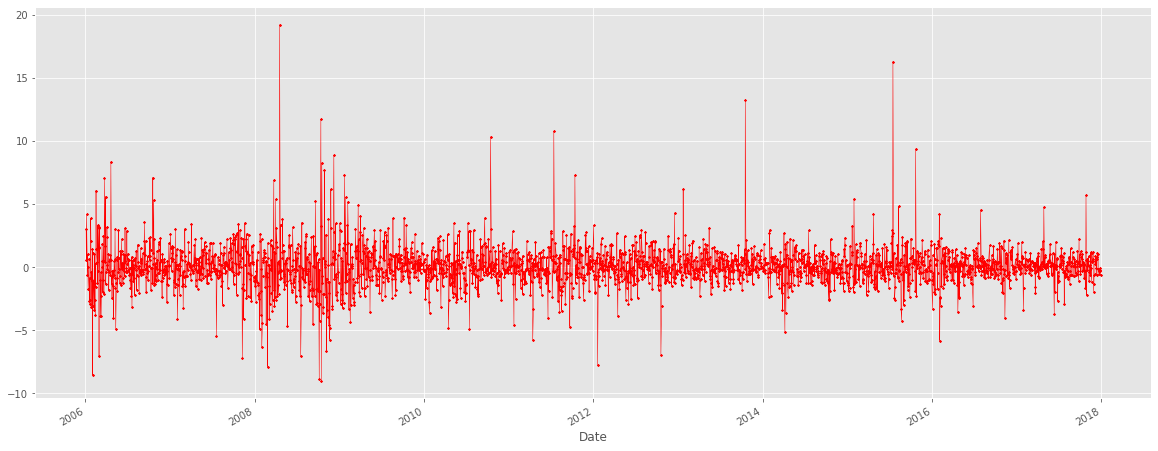

In [5]:
google['Return']=google['Change'].sub(1).mul(100)
google['Return'].plot(linewidth=0.5, color='r', marker='*', markersize=2);

## Comparing Time Series

In [6]:
microsoft=pd.read_csv('stock_data/MSFT_2006-01-01_to_2018-01-01.csv', parse_dates=True, index_col='Date')
microsoft.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


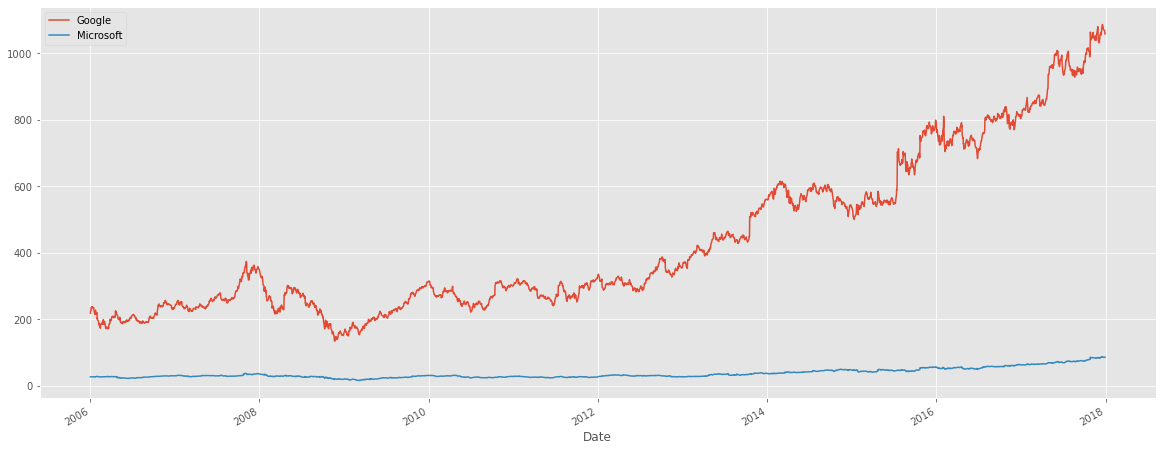

In [7]:
google['High'].plot()
microsoft['High'].plot()
plt.legend(['Google', 'Microsoft']);

### Normalize the Comparison

In [8]:
google['Normalized_High']=(google['High']-google['High'].min())/((google['High'].max()-google['High'].min()))*100
microsoft['Normalized_High']=(microsoft['High']-microsoft['High'].min())/((microsoft['High'].max()-microsoft['High'].min()))*100

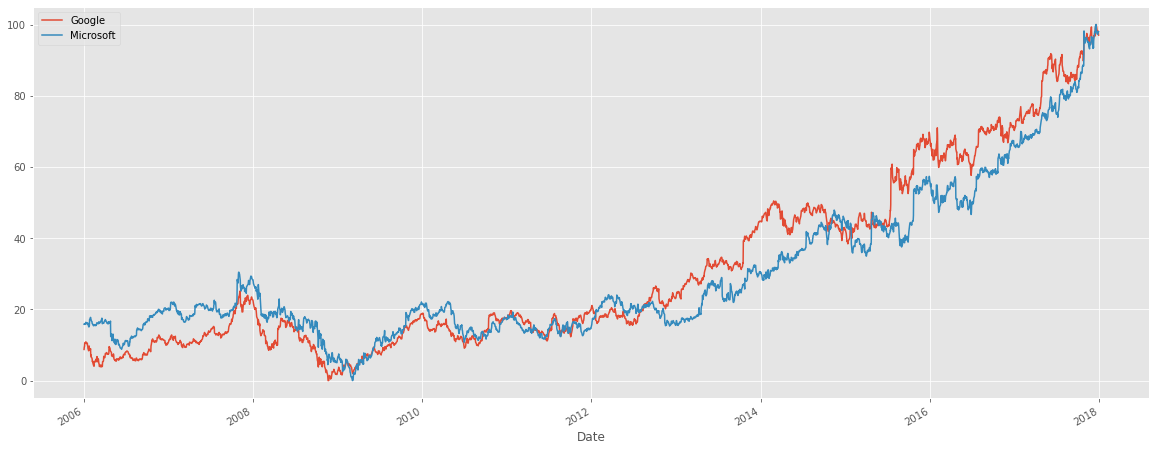

In [9]:
google['Normalized_High'].plot()
microsoft['Normalized_High'].plot()
plt.legend(['Google', 'Microsoft']);

### Window Functions

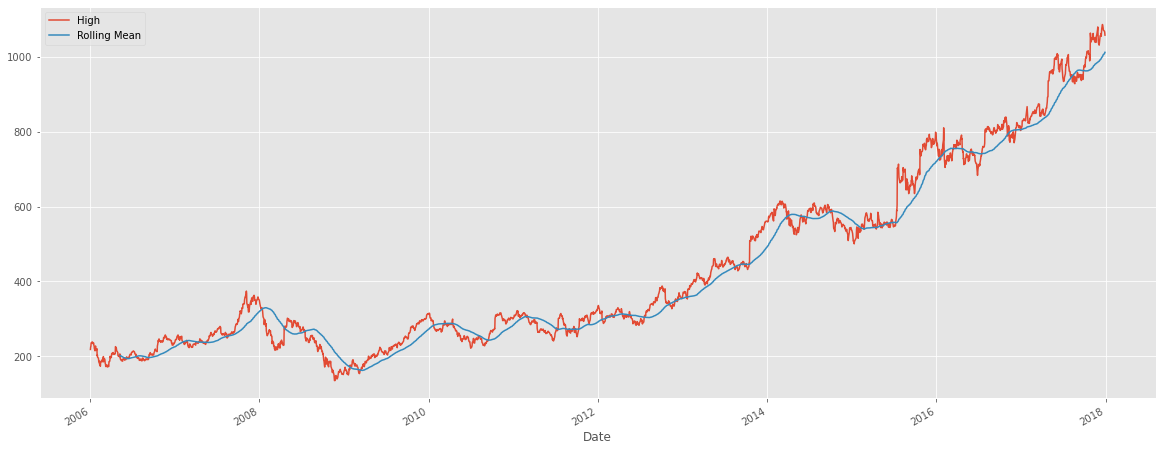

In [10]:
google_rolling=google.High.rolling(90).mean()
google.High.plot()
google_rolling.plot()
plt.legend(['High','Rolling Mean']);

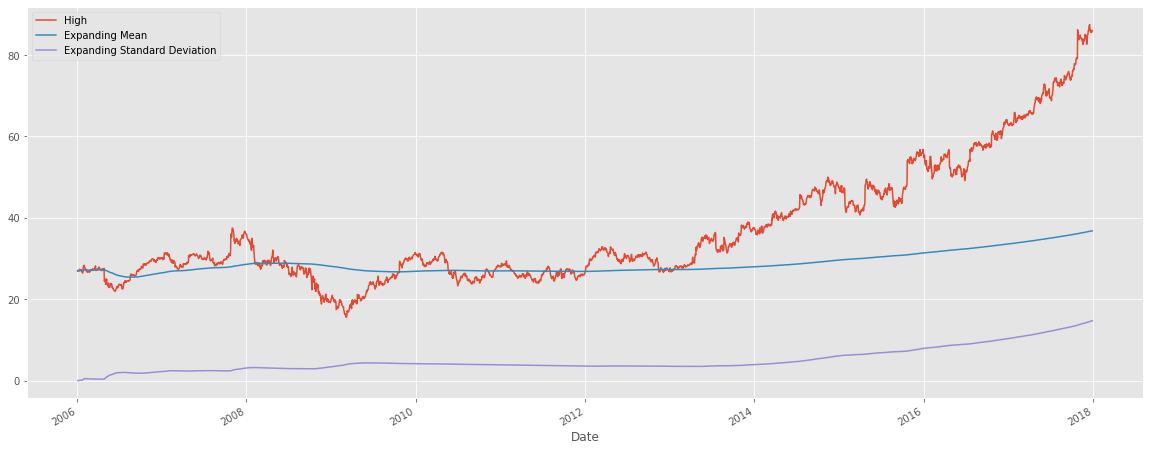

In [11]:
# exanding window functions

microsoft_mean=microsoft.High.expanding().mean()
microsoft_std=microsoft.High.expanding().std()

microsoft.High.plot()
microsoft_mean.plot()
microsoft_std.plot()
plt.legend(['High','Expanding Mean','Expanding Standard Deviation']);

## Stationarity Check

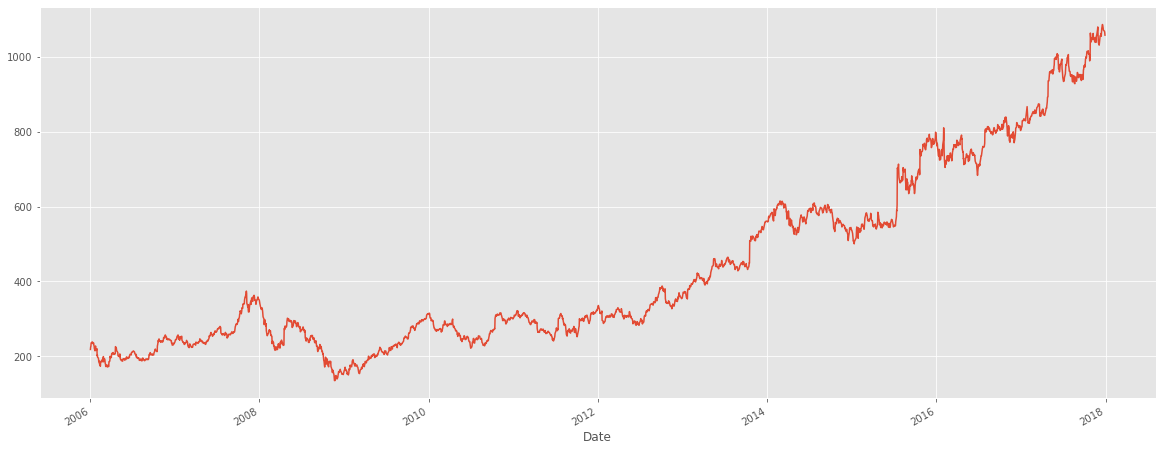

In [12]:
google['High'].plot();

# data is non-stationary

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

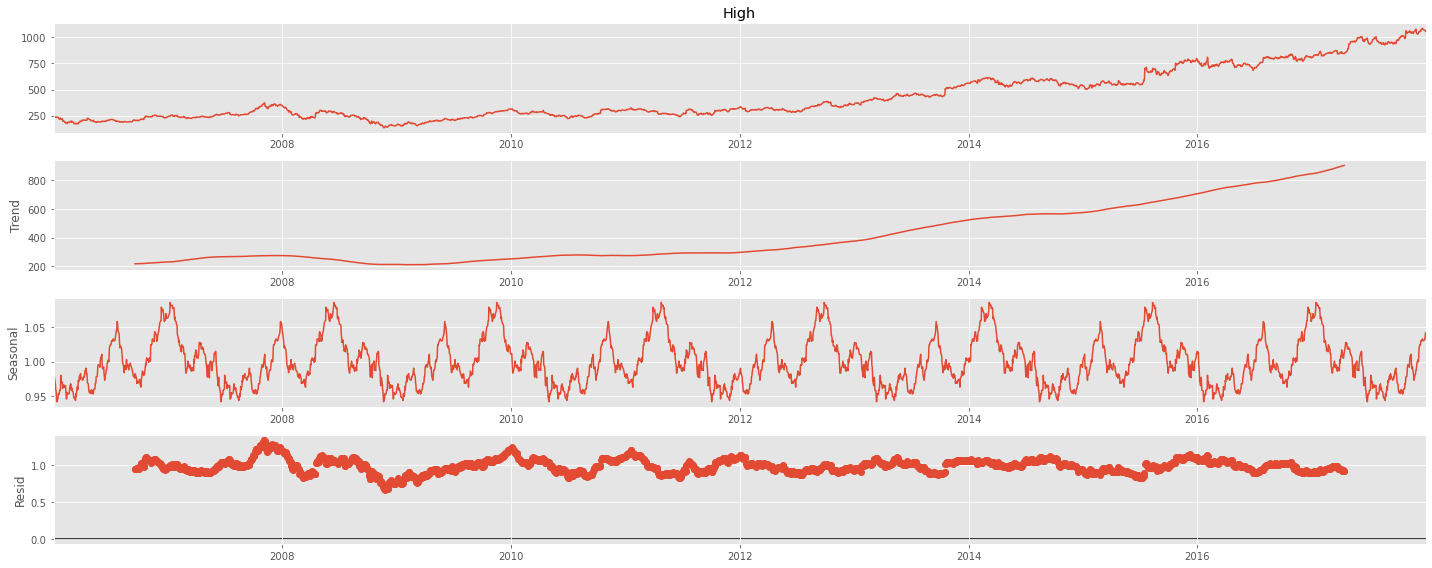

In [14]:
result_google=seasonal_decompose(google['High'], model='multiplicative', period=360)
result_google.plot();

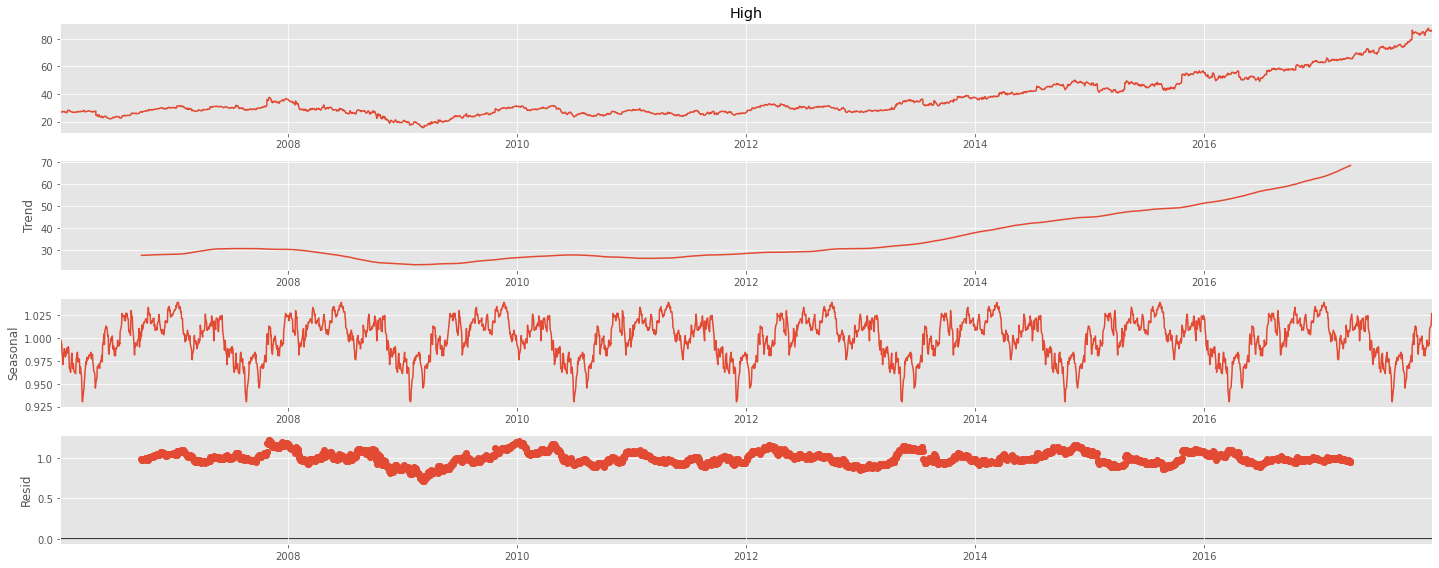

In [15]:
result=seasonal_decompose(microsoft['High'], model='multiplicative', period=360)
result.plot();

## ACF & PACF

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

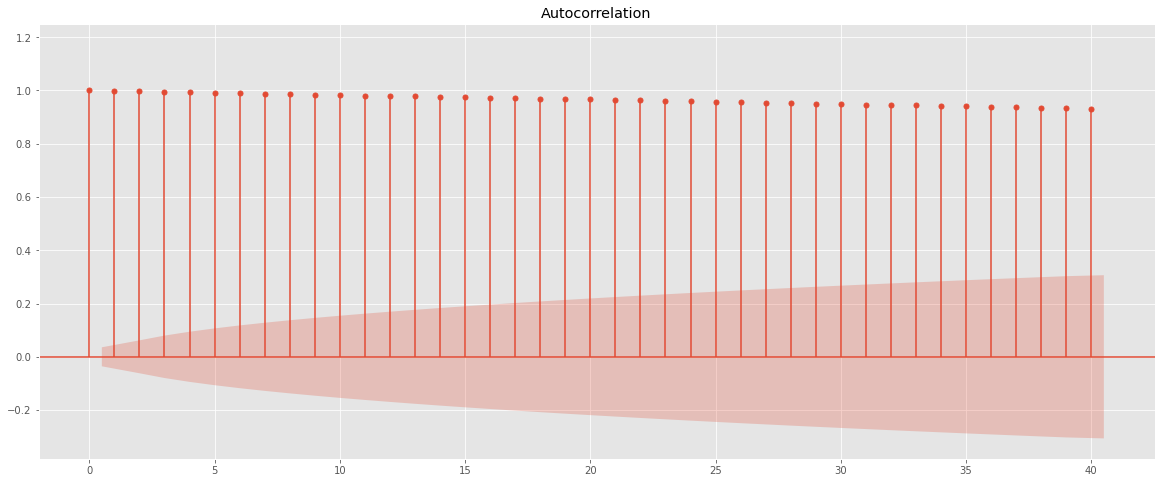

In [17]:
plot_acf(google['Close'], lags=40, auto_ylims=True);

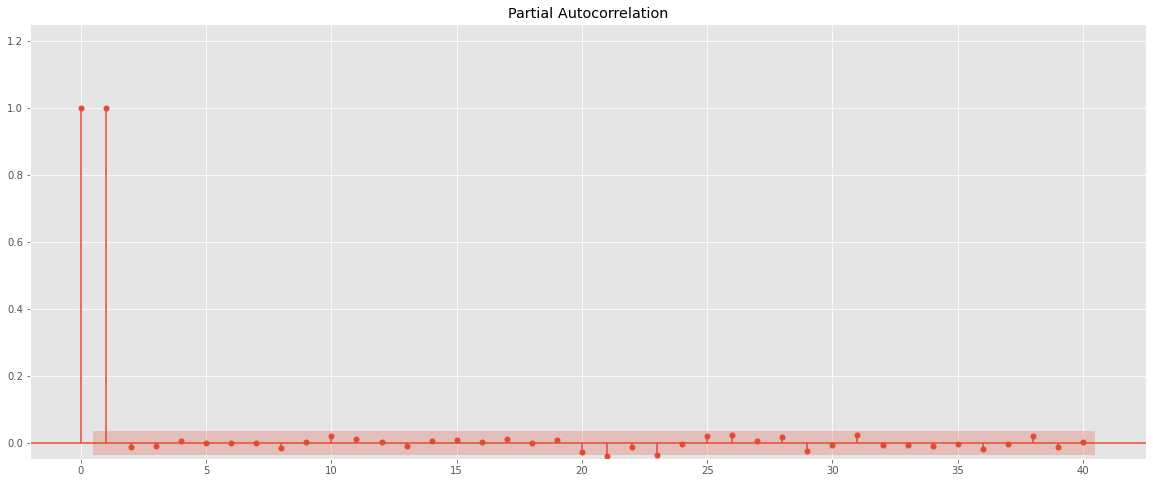

In [18]:
plot_pacf(google['Close'], lags=40, auto_ylims=True);

## Augmented Dicky Fuller Test

In [19]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [20]:
adf_test(google['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic         1.322424
p-value                    0.996732
# lags used               29.000000
# observations          2989.000000
critical value (1%)       -3.432540
critical value (5%)       -2.862507
critical value (10%)      -2.567285
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [21]:
adf_test(microsoft['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic         2.170791
p-value                    0.998858
# lags used               11.000000
# observations          3007.000000
critical value (1%)       -3.432527
critical value (5%)       -2.862502
critical value (10%)      -2.567282
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [22]:
from statsmodels.graphics.tsaplots import month_plot, quarter_plot

In [23]:
gm=google['Close'].resample(rule='M').mean()

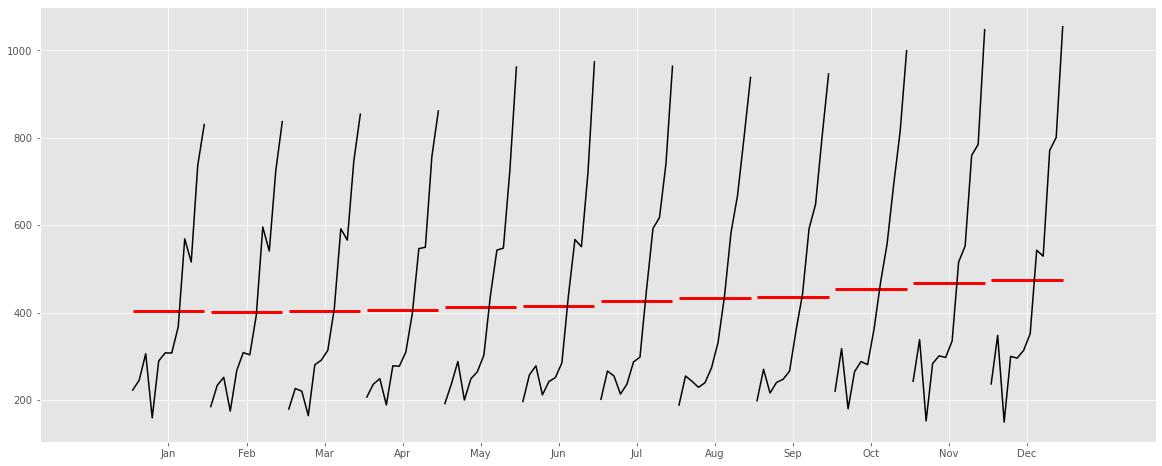

In [24]:
month_plot(gm);

In [25]:
gq=google['Close'].resample(rule='Q').mean()

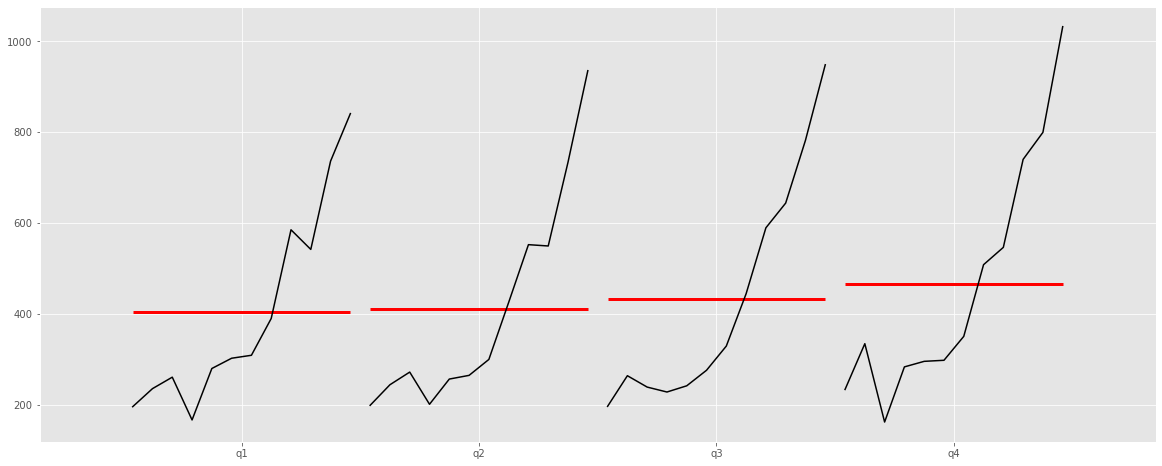

In [26]:
quarter_plot(gq);

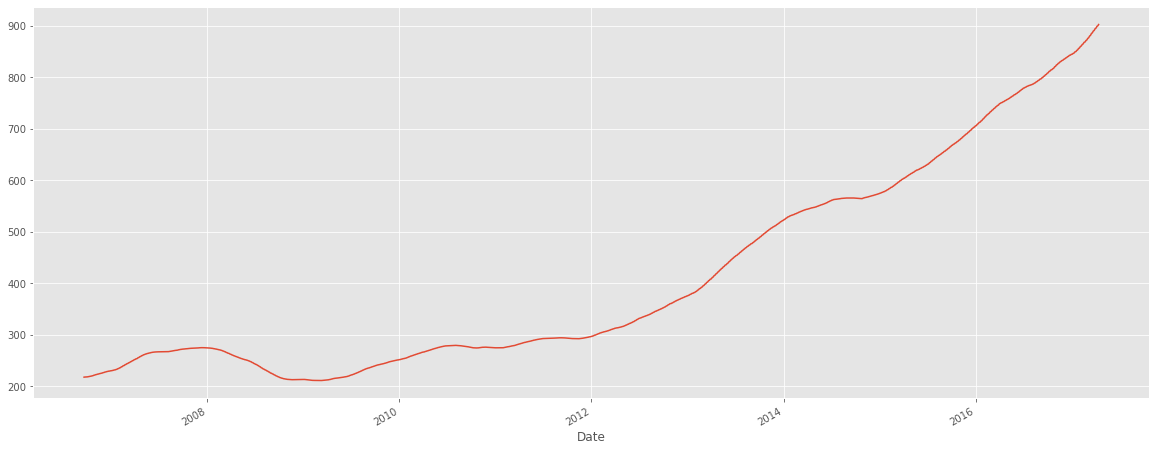

In [27]:
result_google.trend.plot();

# ARIMA Model

In [28]:
from pmdarima import auto_arima

In [29]:
m=microsoft[['Volume']]

In [30]:
m.head()

,Volume
Date,
2006-01-03,79974418
2006-01-04,57975661
2006-01-05,48247610
2006-01-06,100969092
2006-01-09,55627836


In [31]:
def first_day(entry):
    if len(entry):
        return entry[0]

In [32]:
m=m.resample(rule='D').apply(first_day)
m.head(20)

,Volume
Date,
2006-01-03,79974418.0
2006-01-04,57975661.0
2006-01-05,48247610.0
2006-01-06,100969092.0
2006-01-07,NaN
2006-01-08,NaN
2006-01-09,55627836.0
2006-01-10,64924946.0
2006-01-11,70123544.0


In [33]:
m['Volume'].ffill(inplace=True)
m.head(20)

,Volume
Date,
2006-01-03,79974418.0
2006-01-04,57975661.0
2006-01-05,48247610.0
2006-01-06,100969092.0
2006-01-07,100969092.0
2006-01-08,100969092.0
2006-01-09,55627836.0
2006-01-10,64924946.0
2006-01-11,70123544.0


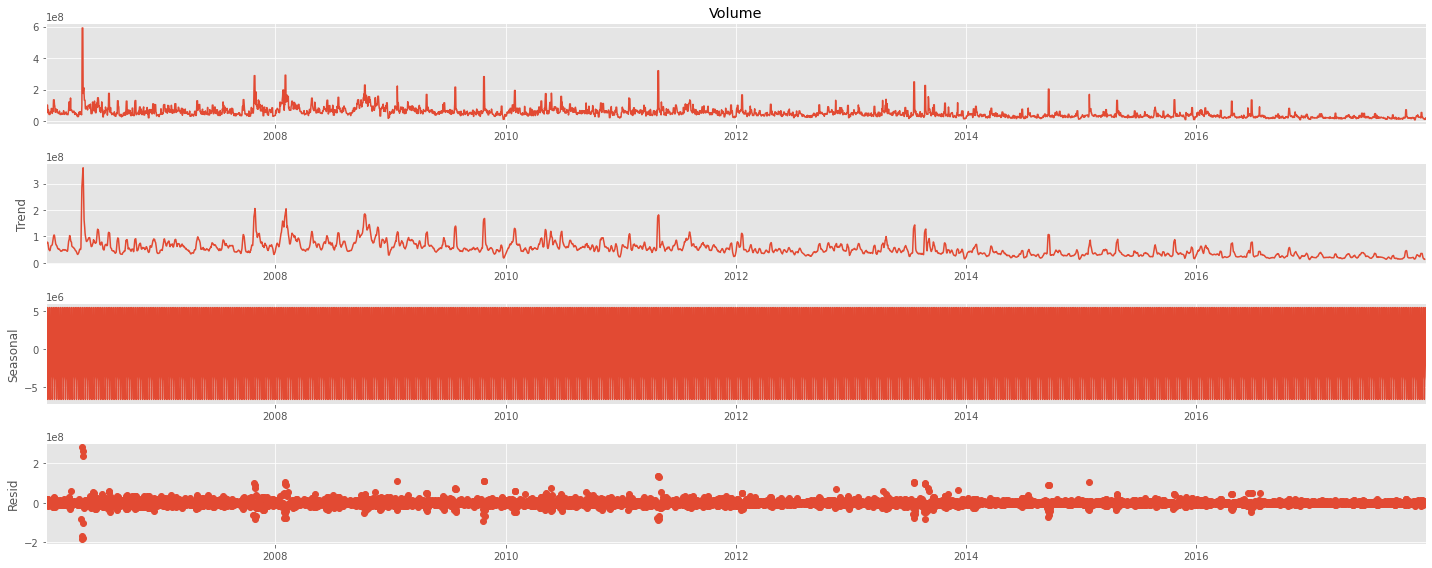

In [34]:
m_sd=seasonal_decompose(m['Volume'])
m_sd.plot();

In [35]:
adf_test(m['Volume'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.248046e+00
p-value                 4.524952e-08
# lags used             3.100000e+01
# observations          4.347000e+03
critical value (1%)    -3.431855e+00
critical value (5%)    -2.862205e+00
critical value (10%)   -2.567124e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [36]:
len(m['Volume'])

4379

In [37]:
train=m.iloc[:-100]
test=m.iloc[-100:]

start=len(train)
end=len(train)+len(test)-1

In [38]:
stepwise_fit=auto_arima(m['Volume'], start_p=0, start_q=0, max_p=6, seasonal=False, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=160598.388, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=160589.144, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=160588.390, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=160596.390, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=160074.909, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=160015.590, Time=1.34 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=160589.952, Time=0.21 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=159923.514, Time=1.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=160190.395, Time=0.29 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=159820.114, Time=1.92 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=160126.802, Time=0.47 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=159819.231, Time=1.89 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=160117.573, Time=0.45 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=159804.283, Time=2.39 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4379
Model:               SARIMAX(5, 1, 3)   Log Likelihood              -79878.684
Date:                Fri, 23 Dec 2022   AIC                         159777.367
Time:                        18:59:11   BIC                         159841.211
Sample:                    01-03-2006   HQIC                        159799.894
                         - 12-29-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.348e+04   9776.016     -2.402      0.016   -4.26e+04   -4322.316
ar.L1         -0.0520      0.082     -0.632      0.528      -0.214       0.109
ar.L2          0.4926      0.082      6.014      0.000       0.332       0.653
ar.L3         -0.0769      0.049     -1.578      0.115      -0.172       0.019
ar.L4         -0.0795      0.022     -3.575      0.000      -0.123      -0.036
ar.L5          0.1266      0.020      6.350      0.000       0.087       0.166
ma.L1         -0.1223      0.083     -1.464      0.143      -0.286       0.041
ma.L2         -0.6202      0.093     -6.651      0.000      -0.803      -0.437
ma.L3         -0.2343      0.061     -3.870      0.000      -0.353      -0.116
sigma2      4.315e+14   3.43e-05   1.26e+19      0.000    4.31e+14    4.31e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1969592.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             5.33
Prob(H) (two-sided):                  0.00   Kurtosis:                       106.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.62e+32. Standard errors may be unstable.
"""

In [39]:
import statsmodels.api as sm

model=sm.tsa.arima.ARIMA(train['Volume'], order=(5,1,3))
result=model.fit()

In [40]:
start=100
end=700

In [41]:
predictions=result.predict(start=start, end=end, typ='levels')

In [42]:
len(predictions)

601

In [43]:
microsoft.index[start:end+1]

DatetimeIndex(['2006-05-26', '2006-05-30', '2006-05-31', '2006-06-01',
               '2006-06-02', '2006-06-05', '2006-06-06', '2006-06-07',
               '2006-06-08', '2006-06-09',
               ...
               '2008-10-01', '2008-10-02', '2008-10-03', '2008-10-06',
               '2008-10-07', '2008-10-08', '2008-10-09', '2008-10-10',
               '2008-10-13', '2008-10-14'],
              dtype='datetime64[ns]', name='Date', length=601, freq=None)

In [44]:
predictions=pd.Series(predictions, index=microsoft.index[start:end+1])

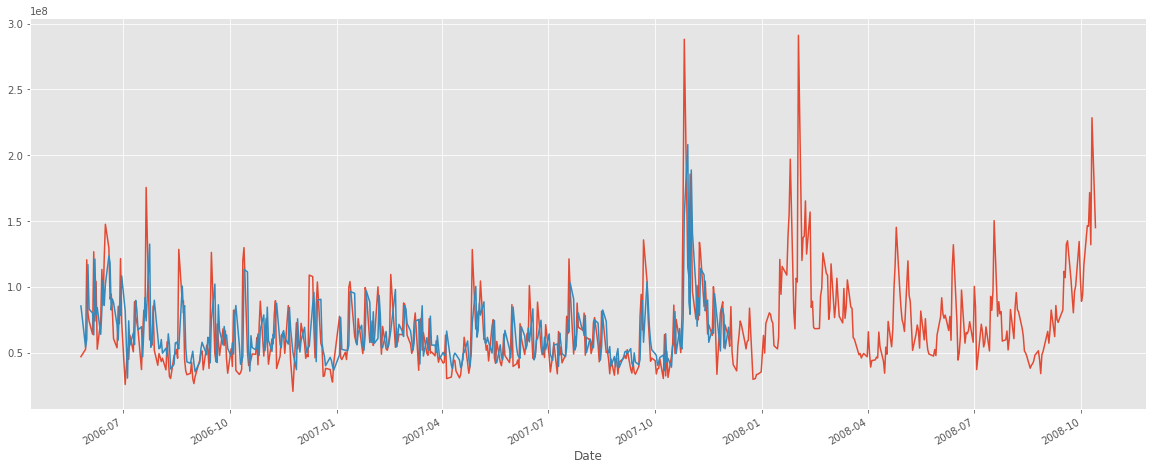

In [45]:
microsoft['Volume'].iloc[start:end].plot()
plt.plot(predictions);

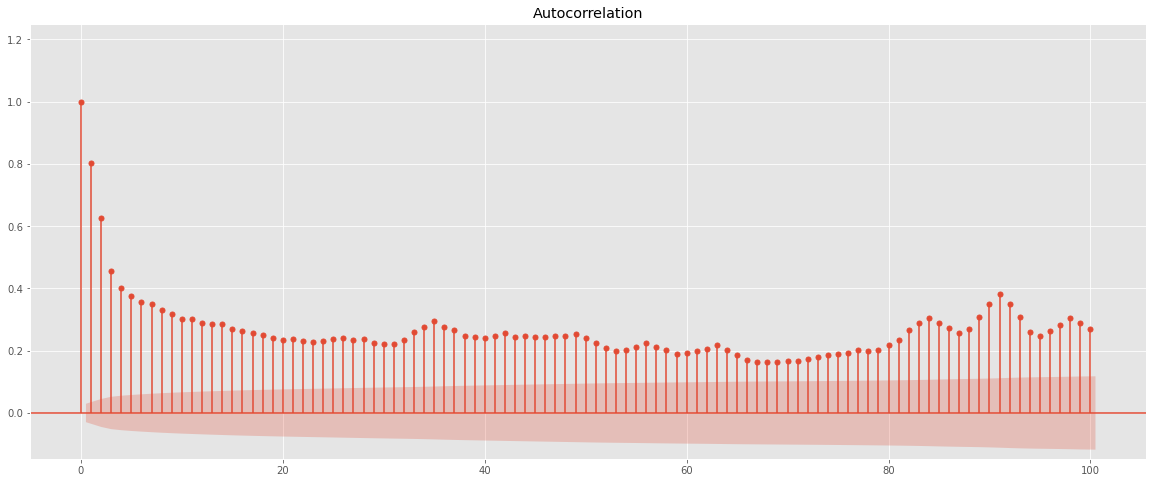

In [46]:
plot_acf(m['Volume'], lags=100, auto_ylims=True);

# SARIMA

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [48]:
x=pd.DataFrame(m_sd.seasonal)

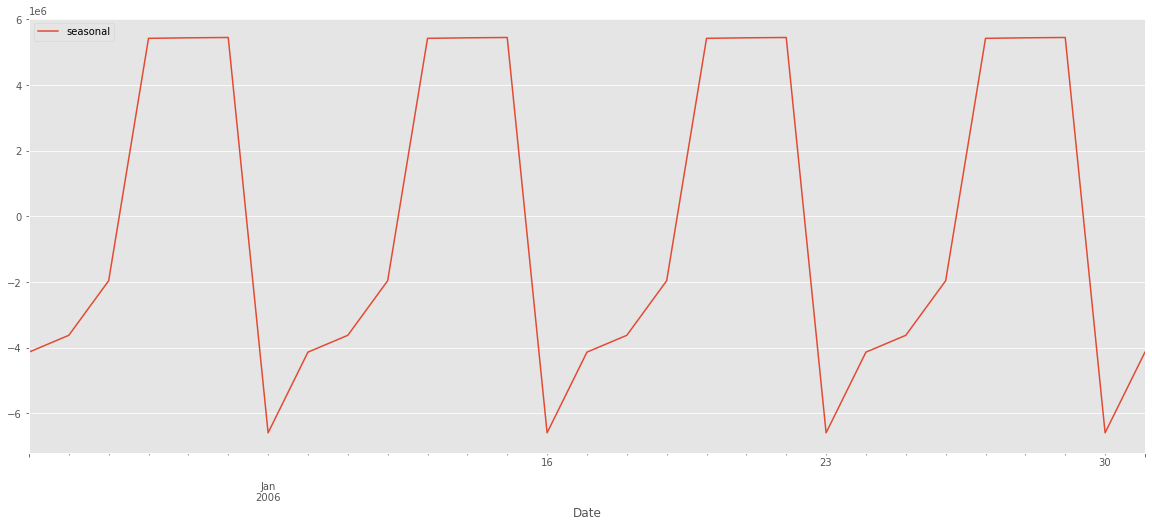

In [49]:
x['2006-01'].plot();

In [50]:
auto_arima(m['Volume'], seasonal=True, m=4).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 4379
Model:             SARIMAX(1, 1, 3)x(0, 0, [1, 2], 4)   Log Likelihood              -79885.307
Date:                                Fri, 23 Dec 2022   AIC                         159784.614
Time:                                        19:01:06   BIC                         159829.305
Sample:                                    01-03-2006   HQIC                        159800.383
                                         - 12-29-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4125      0.007     55.216      0.000       0.398       0.427
ma.L1         -0.5857      0.010    -60.411      0.000      -0.605      -0.567
ma.L2         -0.0397      0.009     -4.410      0.000      -0.057      -0.022
ma.L3         -0.3563      0.007    -49.821      0.000      -0.370      -0.342
ma.S.L4        0.0639      0.009      7.392      0.000       0.047       0.081
ma.S.L8        0.0259      0.014      1.795      0.073      -0.002       0.054
sigma2      4.332e+14   1.58e-17   2.74e+31      0.000    4.33e+14    4.33e+14
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1960711.24
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             5.38
Prob(H) (two-sided):                  0.00   Kurtosis:                       106.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.44e+45. Standard errors may be unstable.
"""

In [51]:
len(m['Volume'])*0.8

3503.2000000000003

In [52]:
train=m.iloc[:3500]
test=m.iloc[3500:]

In [53]:
model=SARIMAX(m['Volume'], order=(1,1,3), seasonal_order=(0, 0, 1, 4))

In [54]:
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82581D+01    |proj g|=  6.10048D-02


 This problem is unconstrained.



At iterate    5    f=  1.82513D+01    |proj g|=  9.82472D-03

At iterate   10    f=  1.82446D+01    |proj g|=  1.60172D-02

At iterate   15    f=  1.82432D+01    |proj g|=  3.40081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     21      1     0     0   1.353D-05   1.824D+01
  F =   18.243125997707182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [55]:
start=len(train)
end=len(train)+len(test)-1

In [56]:
predictions=results.predict(start,end,typ='levels').rename('SARIMA Predictions')

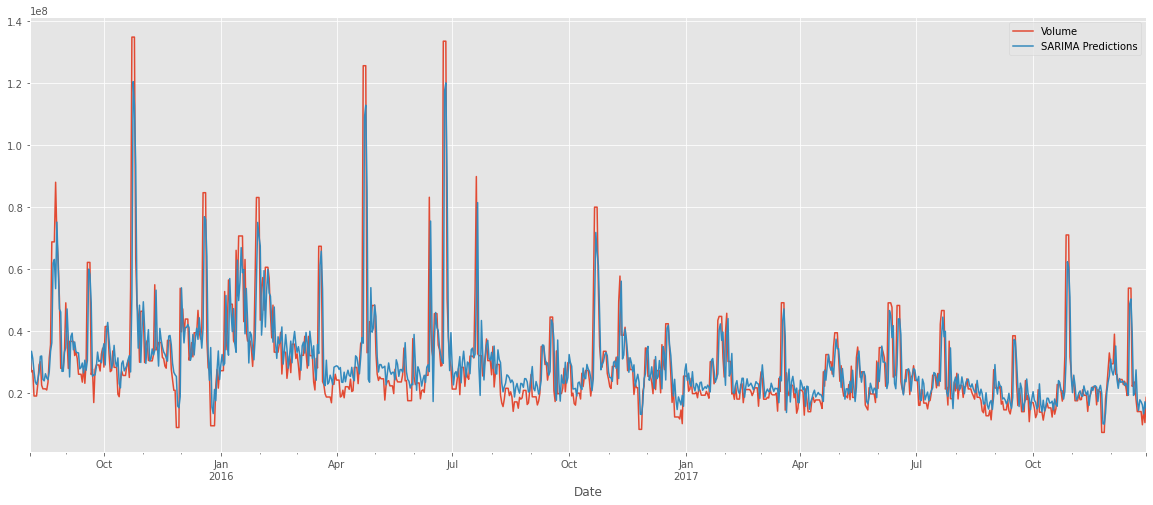

In [57]:
test['Volume'].plot(legend=True)
predictions.plot(legend=True);

In [58]:
from statsmodels.tools.eval_measures import rmse, mse

In [59]:
error=rmse(test['Volume'], predictions)
error

10452682.307722462